<a href="https://colab.research.google.com/github/Orbeyar1/Voice-Disorder-Detection-Project/blob/main/Audio_split_via_VAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Change this based on the drive being used
my_voice_data = '/content/drive/MyDrive/Study_materials/Voice samples study'

Mounted at /content/drive


In [2]:
## Imports

import os
import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from IPython.display import Audio

print(torch.__version__)
print(torchaudio.__version__)

## Use cuda if available
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.0.1+cu118
2.0.2+cu118
cpu


In [3]:
# Define constants
wanted_sample_rate = 16000

audio_labels = ["normal pitch E","low pitch E","high pitch E",
                "normal pitch Ah","low pitch Ah","high pitch Ah",
                "normal pitch Ooh","low pitch Ooh","high pitch Ooh",
                "normal pitch Mmmmm"]

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

In [4]:
### Load Data ##

# First we count number of .wav files
counter = 0
for filename in os.listdir(my_voice_data):
    if filename.endswith("wav"):
      counter +=1
print(f'We have {counter} .wav files')

# We bucket sort all patients into an array of mono-channel, 16k S/R audiotorch tensors.
patients_audio_list = [None] * (counter + 2) # We add +2 because there's a mis-lable in filenames
for filename in os.listdir(my_voice_data):
    if filename.endswith("wav"):
      # Extract patient's ID from filename
        _, numberwav = filename.split(" ")
        number = numberwav.split(".")
        patient_id = number[0]
        waveform, sample_rate = torchaudio.load(my_voice_data +'/'+ filename)
        transform = T.Resample(sample_rate, wanted_sample_rate)
        waveform = transform(waveform)
        waveform_mono = torch.mean(waveform, dim=0).unsqueeze(0)
        # if sample_rate != wanted_sample_rate:
        #   waveform = torchaudio.functional.resample(waveform, sample_rate, wanted_sample_rate)
        patients_audio_list[int(patient_id)] = (int(patient_id),waveform_mono,wanted_sample_rate)


We have 234 .wav files


In [10]:
!pip install webrtcvad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import webrtcvad
import numpy as np

def split_audio_with_vad(audio_tensor, sample_rate):
    vad = webrtcvad.Vad()
    vad.set_mode(3)  # Set aggressiveness mode (0-3)

    audio_array = np.array(audio_tensor)
    audio_int16 = np.int16(audio_array * 32768).tobytes()

    frame_duration = 30  # Frame duration in milliseconds
    frame_size = int(sample_rate * frame_duration / 1000)
    num_frames = len(audio_array) // frame_size

    non_silent_frames = []
    for i in range(num_frames):
        frame_start = i * frame_size
        frame_end = (i + 1) * frame_size
        frame = audio_int16[frame_start:frame_end]

        is_speech = vad.is_speech(frame, sample_rate)
        if is_speech:
            non_silent_frames.append(frame)

    # Convert frames back to audio tensor
    non_silent_audio = np.frombuffer(b''.join(non_silent_frames), dtype=np.int16)
    non_silent_audio_tensor = non_silent_audio.astype(np.float32) / 32768.0

    return non_silent_audio_tensor

# Example usage
audio_tensor = ...  # Replace with your audio tensor
sample_rate = 16000  # Desired sample rate

non_silent_audio = split_audio_with_vad(audio_tensor, sample_rate)

In [5]:
def split_audio_without_silence(audio_tensor, sample_rate):
    # Convert audio tensor to numpy array
    audio_array = np.array(audio_tensor)

    # Find non-silent intervals in the audio
    intervals = librosa.effects.split(audio_array, top_db=20)
    # Initialize an empty list to store the non-silent audio chunks
    chunks = []

    # Extract non-silent intervals as audio chunks
    for interval in intervals:
        start_sample, end_sample = interval
        chunk = audio_array[0][start_sample:end_sample]
        chunks.append(chunk)

    return chunks

# Example usage
audio_tensor = patients_audio_list[1][1]  # Replace with your audio tensor
sample_rate = 16000  # Desired sample rate

audio_chunks = split_audio_without_silence(audio_tensor, wanted_sample_rate)


In [6]:
Audio(audio_chunks[16], rate=sample_rate)

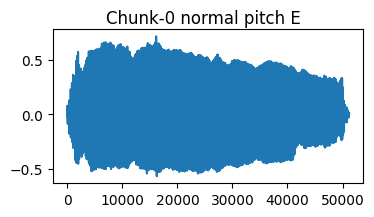

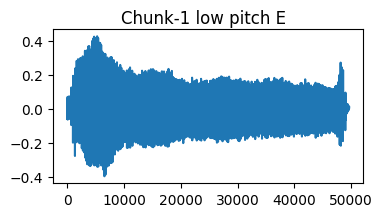

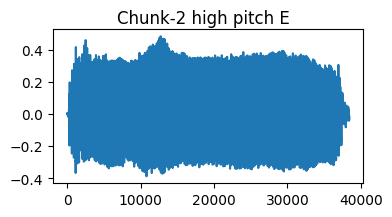

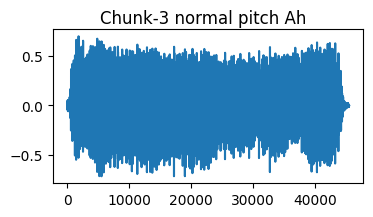

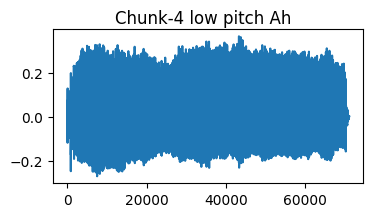

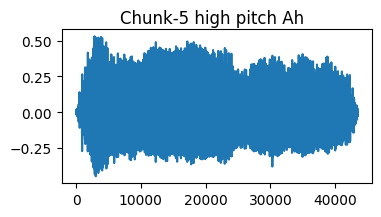

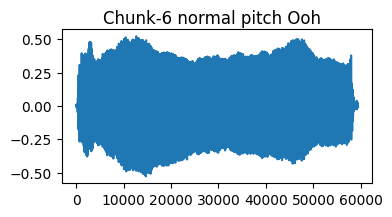

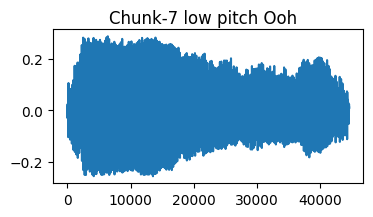

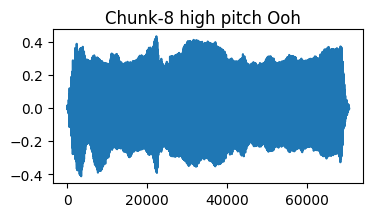

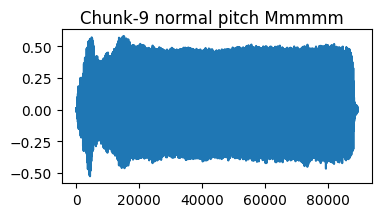

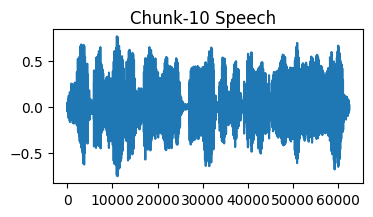

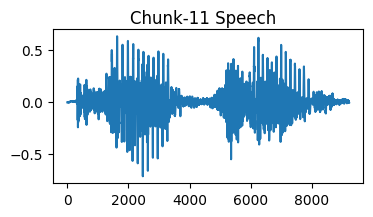

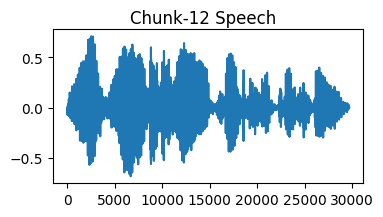

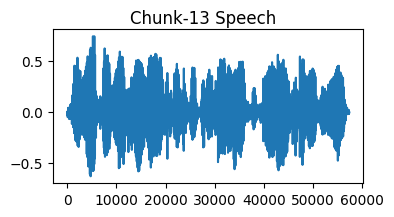

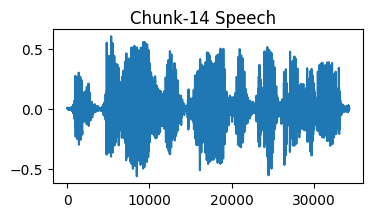

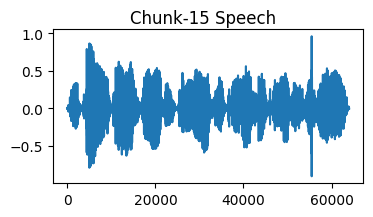

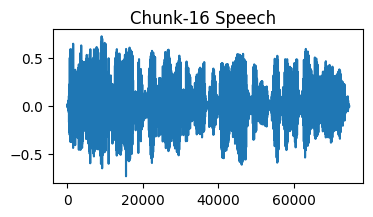

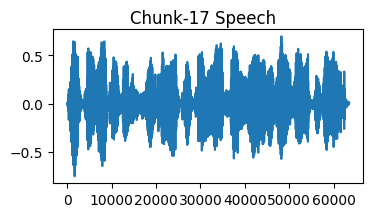

In [7]:
## print chunks waveforms for observation and debugging
fignum = 1
for chunk in audio_chunks:
  fig = plt.figure(fignum,figsize=(4,2))
  if fignum-1 < len(audio_labels):
    fig.suptitle(f'Chunk-{fignum-1} {audio_labels[fignum-1]}', fontsize=12)
  else:
    fig.suptitle(f'Chunk-{fignum-1} Speech', fontsize=12)
  plt.plot(chunk)
  fignum = fignum+1